# Projekt przewidywania temperatury

### Przedmiot projektu

Projekt obejmuje stworzenie algorytmu uczenia maszynowego w celu przewidywania pogody dla miasta Szeged na Węgrzech.<br>
Dane były pobierane w przedziale czasowym od 2006-01-01 00:00:00 do 2016-12-31 23:00:00 o każdej pełnej godzine.

In [1]:
# Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import sklearn

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load dataset
df = pd.read_csv("weatherHistory.csv")
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
# shape of dataframe
df_shape = df.shape
print(f"Dataset weatherHistory posiada {df_shape[1]} cech oraz {df_shape[0]} obserwacji.")

Dataset weatherHistory posiada 12 cech oraz 96453 obserwacji.


In [4]:
# data frame information about features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [5]:
pd.DataFrame(df.isna().mean()).T

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,0.0,0.0,0.00536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# description for numerical features
df.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


#### Wnioski

Data frame posiada wartości NaN dla cechy 'Precip Type', co stanowi 5.3%% (promila) wszystkich danych. <br> <br>

Kolumny kategoryczne: Formatted Date, Summary, Precip Type, Daily Summary <br>
Kolumny numeryczne: Temperature (C), Apparent Temperature (C), Humidity, Wind Speed (km/h), Wind Bearing (degrees), Visibility (km), Loud Cover, Pressure (millibars)

Kolumna Loud Cover posiada tylko wartości 0, dlatego nie jest istotna dla data frame.

## Feature engineering

### Zamiana pustych wartości dla columny 'Precip Type'


In [7]:
# value counts for Precip Type
df["Precip Type"].value_counts(dropna=False)

rain    85224
snow    10712
NaN       517
Name: Precip Type, dtype: int64

In [8]:
# create dataframe with  empyt's values Precip type and display 10 samples
df_precip_null = df.loc[df["Precip Type"].isnull()]
df_precip_null.sample(10)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
95467,2016-10-27 23:00:00.000 +0200,Clear,NaN,4.900000,3.366667,0.79,6.8103,11.0,0.0000,0.0,1032.22,Partly cloudy starting in the morning continui...
95386,2016-10-24 14:00:00.000 +0200,Partly Cloudy,NaN,17.216667,17.216667,0.67,15.5848,180.0,9.6278,0.0,1023.41,Foggy until morning.
95362,2016-10-23 14:00:00.000 +0200,Mostly Cloudy,NaN,13.505556,13.505556,0.71,7.9695,147.0,9.9981,0.0,1021.01,Foggy starting overnight continuing until morn...
95559,2016-10-30 18:00:00.000 +0100,Clear,NaN,8.222222,6.238889,0.73,11.6403,313.0,0.0000,0.0,1024.91,Clear throughout the day.
52677,2012-04-11 21:00:00.000 +0200,Mostly Cloudy,NaN,12.566667,12.566667,0.43,9.0160,159.0,9.9820,0.0,1001.92,Mostly cloudy until night.
52798,2012-04-16 22:00:00.000 +0200,Mostly Cloudy,NaN,10.877778,10.877778,0.76,20.6402,342.0,16.1000,0.0,1007.04,Partly cloudy throughout the day.
95489,2016-10-28 21:00:00.000 +0200,Clear,NaN,6.816667,5.038889,0.75,9.0804,235.0,0.0000,0.0,1032.04,Clear throughout the day.
52765,2012-04-15 13:00:00.000 +0200,Partly Cloudy,NaN,16.883333,16.883333,0.61,9.4829,308.0,11.1090,0.0,996.10,Mostly cloudy until night.
95205,2016-10-18 01:00:00.000 +0200,Mostly Cloudy,NaN,8.127778,5.211111,0.75,18.3540,142.0,16.1000,0.0,1028.48,Mostly cloudy throughout the day.
94271,2016-11-01 03:00:00.000 +0100,Partly Cloudy,NaN,4.800000,3.088889,0.94,7.3738,300.0,0.0000,0.0,1021.54,Partly cloudy starting in the afternoon.


In [9]:
# check teperatures min and max for NaNs
temp_max = round(df_precip_null["Temperature (C)"].max(),2)
temp_min = round(df_precip_null["Temperature (C)"].min(),2)
print(f"Temperatura dla brakujących wartości max={temp_max}, min={temp_min} w kolumne Precip Type")

Temperatura dla brakujących wartości max=25.04, min=1.26 w kolumne Precip Type


#### Wnioski:

Minimalna wartość temperatury dla NaN dla cechy Precip Type to 1.26 stopni, dlatego puste wartości zamieniono na wartość 'rain'.

In [10]:
# replace NaNs with 'rain'
df['Precip Type'] = df['Precip Type'].replace(np.NaN, 'rain')
df["Precip Type"].value_counts(dropna=False)

rain    85741
snow    10712
Name: Precip Type, dtype: int64

### Stworzenie kolumn dla miesiąca i godziny

In [11]:
# add column with month
df["Month"] = df["Formatted Date"].apply(lambda x: int(x[5:7]))

In [12]:
# add column with hout
df["Hour"] = df["Formatted Date"].apply(lambda x: int(x[11:13]))

### Grupowanie kolumn miesiąca i godziny na pory roku i dnia

In [13]:
# add column with grupped month

# 1 - Winter
# 2 - Spring
# 3 - Summer
# 4 - Autumn

season = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}
df["year_season"] = df["Month"].map(season)

In [14]:
# add column with grupped hour

# 1 - Morning
# 2 - Afternoon
# 3 - Evening
# 4 - Night

parts_of_the_day = {5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 4, 0: 4, 1: 4, 2: 4, 3: 4, 4: 4}

df["day_part"] = df["Hour"].map(parts_of_the_day)

### Usuwanie kolumn

In [15]:
# print column where is only one unique value

for col in df.columns:
    a = df[col].unique()
    if len(a) == 1:
        print(col, a)

Loud Cover [0.]


In [16]:
# drop column 'Loud Cover' - because it has only 1 unique value
df = df.drop('Loud Cover', axis=1)

In [17]:
# drop column 'Formatted Date' - because features for month and hour have been created from this feature
df = df.drop('Formatted Date', axis=1)

### Columny kategoryczne

In [18]:
# create features for snow and rain from Precip Type feature, and removed it
df = pd.get_dummies(df, columns = ['Precip Type'])
df.rename(columns={'Precip Type_rain': 'Rain', 'Precip Type_snow': 'Snow'}, inplace=True)

In [19]:
# create features for each kind of "Summary", and separate the summary where value is concated with separator ' and '. 
# Assign '1' valuer for observation when is has this kind of value

def create_summary_columns(column_name, data_frame):
    """Create column if it is not exist in currwent dataframe and assign '0'.
    :param column_name: name of column wich will be created
    :param data_frame: data frame
    """
    if column_name not in data_frame.columns:
        data_frame[column_name] = 0
        
separator = " and " # separator for concated values
list_of_values = df["Summary"].unique() # list of unique values in feature 'Summary'

# Summary column
# create new columns from Summary unique values
for unique_value in list_of_values:
    if separator in unique_value:
        value_list = unique_value.split(separator)
        for col_name in value_list:
            create_summary_columns(col_name, df)
            df.loc[df["Summary"] == unique_value, col_name] = 1
    else:
        create_summary_columns(unique_value, df)
        df.loc[df["Summary"] == unique_value, unique_value] = 1
        
# drop feature 'Summary'
df = df.drop('Summary', axis=1)

### Columny numeryczne

In [20]:
# Add column with temperature difference between measured and apparent temperature 

# this column will be not used to create a predict model
df["temperature difference"] = df["Apparent Temperature (C)"] - df["Temperature (C)"]
df = df.drop("Apparent Temperature (C)", axis=1)

In [21]:
# display data frame
df.head()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Month,Hour,year_season,...,Foggy,Breezy,Clear,Humid,Windy,Dry,Dangerously Windy,Light Rain,Drizzle,temperature difference
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,4,0,2,...,0,0,0,0,0,0,0,0,0,-2.083333
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,4,1,2,...,0,0,0,0,0,0,0,0,0,-2.127778
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,4,2,2,...,0,0,0,0,0,0,0,0,0,0.000000
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,4,3,2,...,0,0,0,0,0,0,0,0,0,-2.344444
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,4,4,2,...,0,0,0,0,0,0,0,0,0,-1.777778


#### Wnioski:
Kolumny kategoryczne zostały usunięte lub na ich podstawie wybano nowe, kolumny ktore mogą być wykorzystane do storzenia modelu.

Cecha 'Daily Summary' nie została na chwile obecą usunięta, bo zostanie zwizualizowana poniźej.

## Analiza wykresów cech

In [22]:
columns = df.columns
print('Liczba cech:\t', len(columns))
print('\nNazwy cech:')
for column in columns:
    print(column, end=", ")

Liczba cech:	 26

Nazwy cech:
Temperature (C), Humidity, Wind Speed (km/h), Wind Bearing (degrees), Visibility (km), Pressure (millibars), Daily Summary, Month, Hour, year_season, day_part, Rain, Snow, Partly Cloudy, Mostly Cloudy, Overcast, Foggy, Breezy, Clear, Humid, Windy, Dry, Dangerously Windy, Light Rain, Drizzle, temperature difference, 

In [23]:
# data frame describe for all features after features engineering
# for: Temperature (C), Humidity, Wind Speed (km/h), Wind Bearing (degrees), Visibility (km), Pressure (millibars), 
# Daily Summary, Month, Hour, year_season, day_part
df[['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 
    'Pressure (millibars)', 'Month', 'Hour', 'year_season', 'day_part']].describe()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Month,Hour,year_season,day_part
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000
mean,11.932678,0.734899,10.810640,187.509232,10.347325,1003.235956,6.523799,11.500327,2.503323,2.499953
std,9.551546,0.195473,6.913571,107.383428,4.192123,116.969906,3.448495,6.922081,1.114696,1.118026
min,-21.822222,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,4.688889,0.600000,5.828200,116.000000,8.339800,1011.900000,4.000000,6.000000,2.000000,1.000000
50%,12.000000,0.780000,9.965900,180.000000,10.046400,1016.450000,7.000000,12.000000,3.000000,2.000000
75%,18.838889,0.890000,14.135800,290.000000,14.812000,1021.090000,10.000000,18.000000,3.000000,3.000000
max,39.905556,1.000000,63.852600,359.000000,16.100000,1046.380000,12.000000,23.000000,4.000000,4.000000


In [24]:
# data frame describe for all features after features engineering
df[['Rain', 'Snow', 'Partly Cloudy', 'Mostly Cloudy', 'Overcast', 'Foggy', 'Breezy', 'Clear', 'Humid', 'Windy', 'Dry', 'Dangerously Windy', 'Light Rain','Drizzle', 'temperature difference']].describe()
    

,Rain,Snow,Partly Cloudy,Mostly Cloudy,Overcast,Foggy,Breezy,Clear,Humid,Windy,Dry,Dangerously Windy,Light Rain,Drizzle,temperature difference
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.00000,96453.000000,96453.000000,96453.000000
mean,0.888941,0.111059,0.334774,0.297544,0.178087,0.074513,0.015759,0.112905,0.000664,0.001659,0.001410,0.00001,0.000653,0.000404,-1.077650
std,0.314207,0.314207,0.471914,0.457180,0.382588,0.262605,0.124542,0.316478,0.025751,0.040695,0.037524,0.00322,0.025549,0.020104,1.678694
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-10.183333
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-2.216667
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,4.811111


In [25]:
(df['Overcast'].dtypes != 'object') and (len(df['Overcast'].unique()) > 2)

False

### Histogramy cech
histogramy dla każdej numerycznej cechy raz z zaznaczonymi średnią (czerwona lini) oraz medianą (niebieska linia)

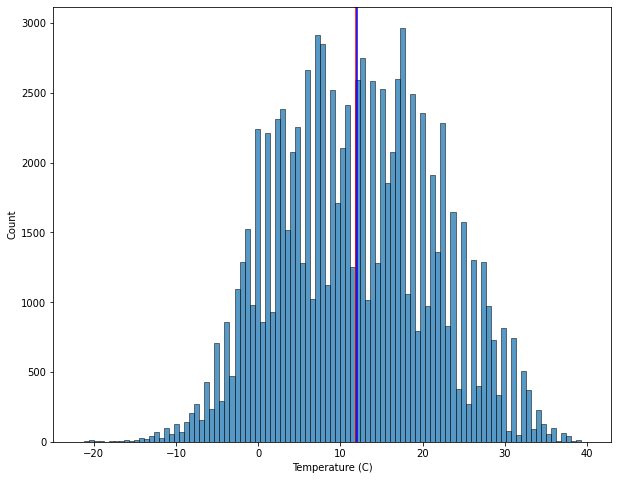

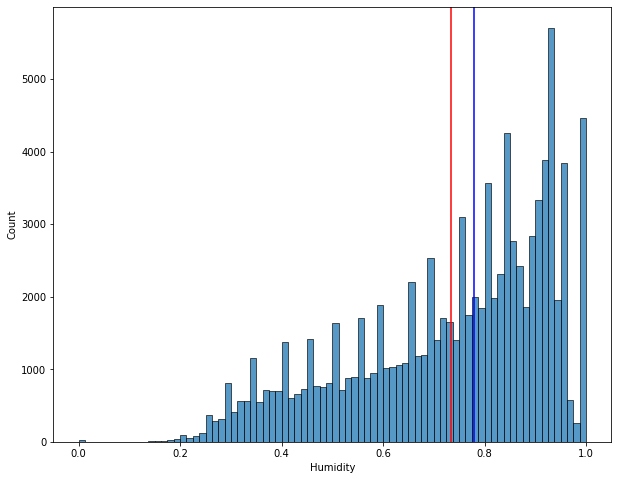

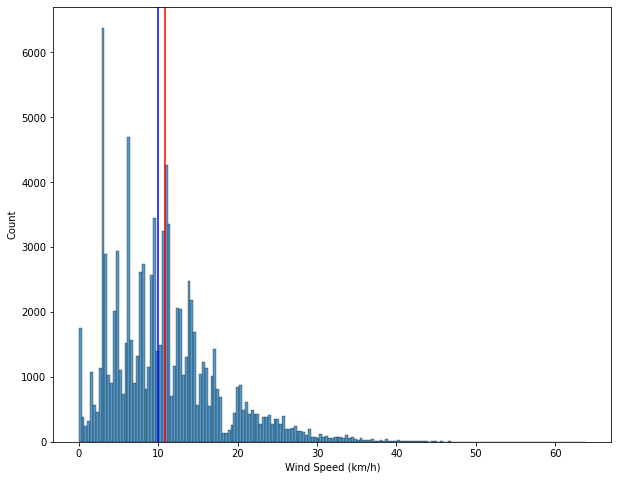

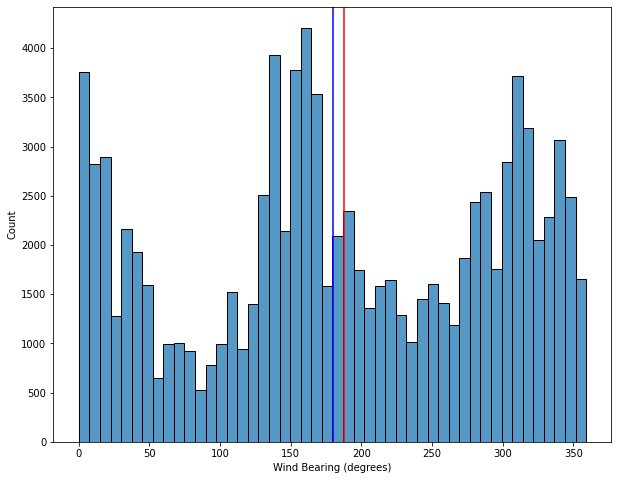

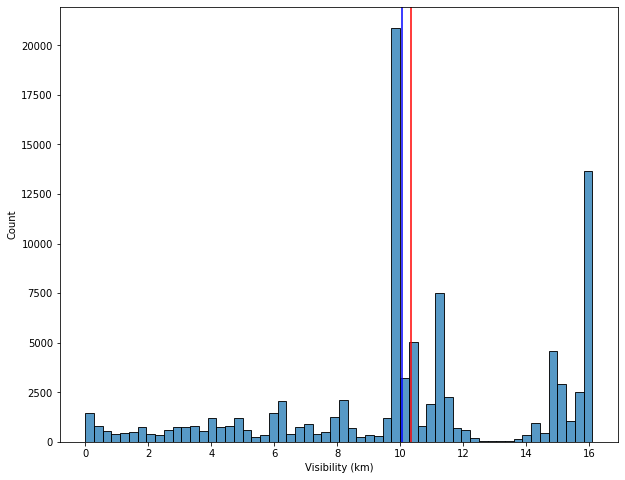

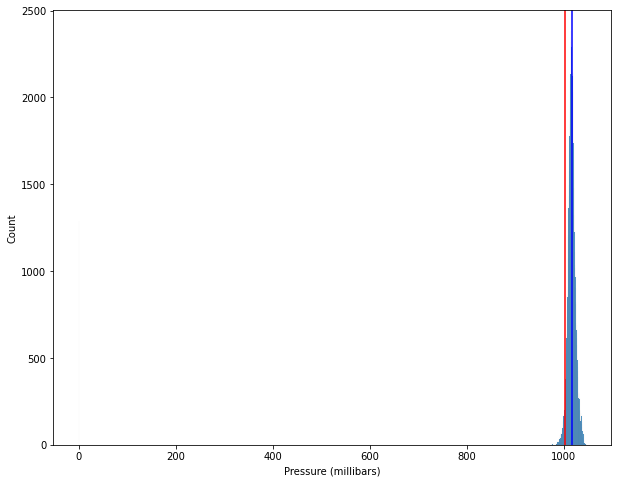

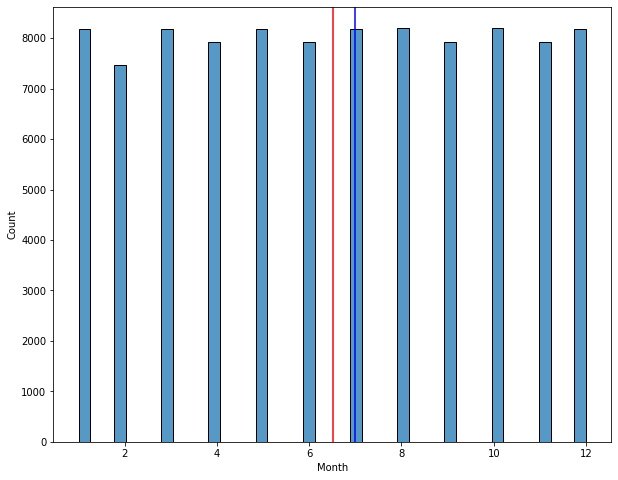

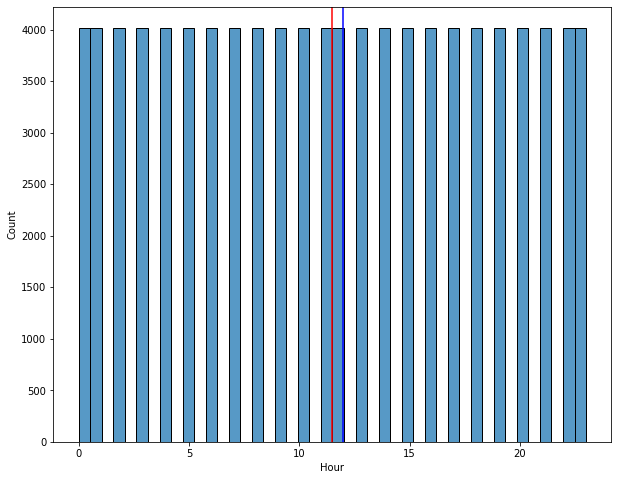

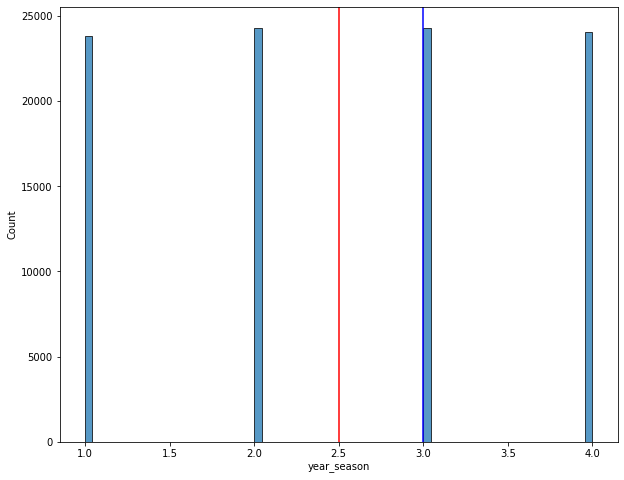

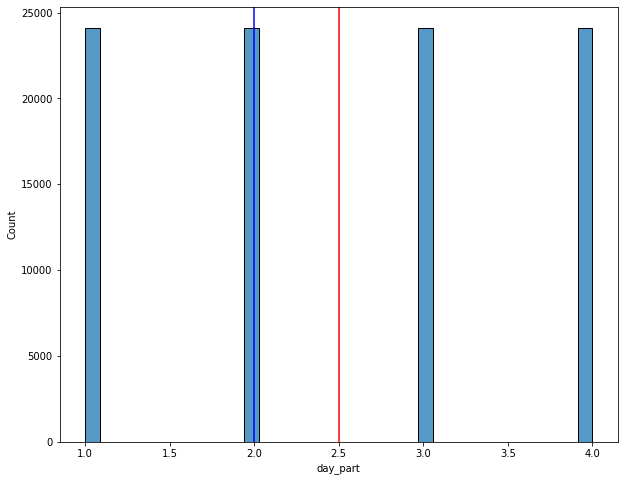

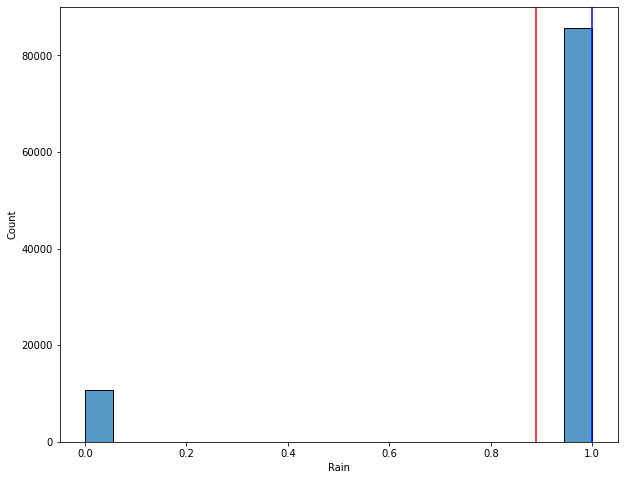

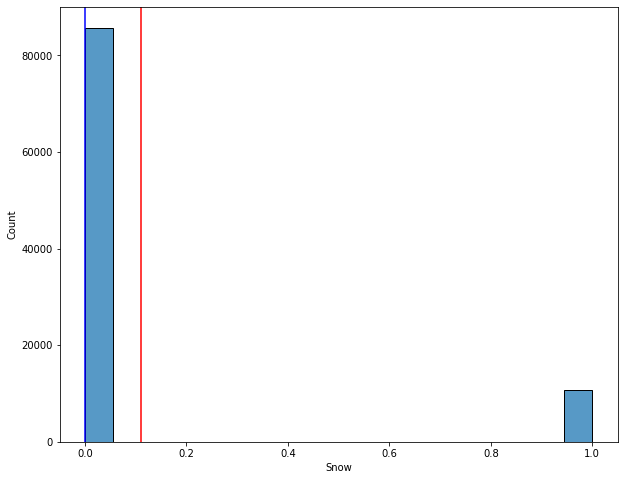

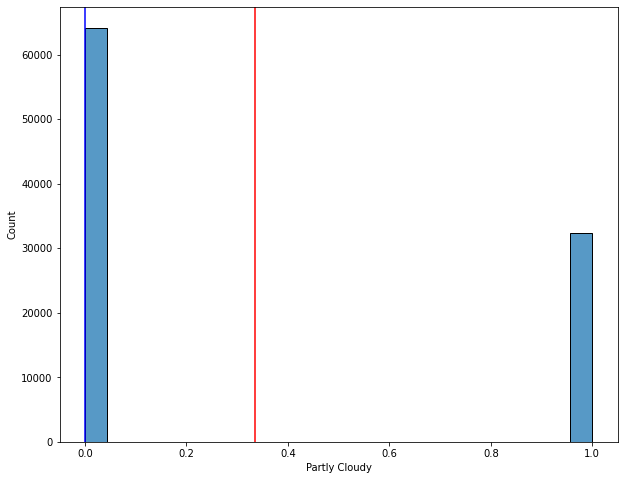

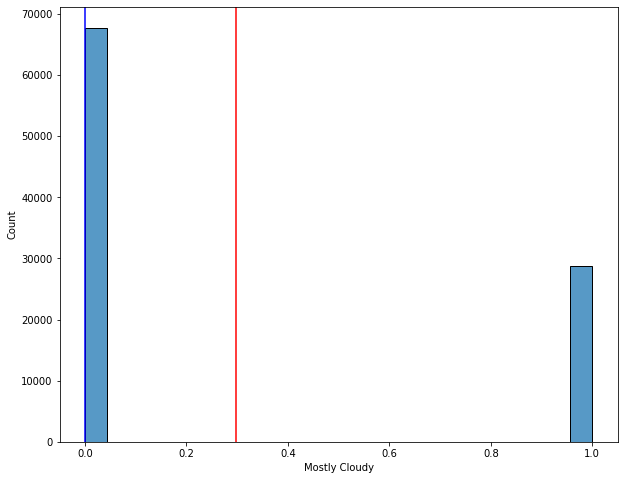

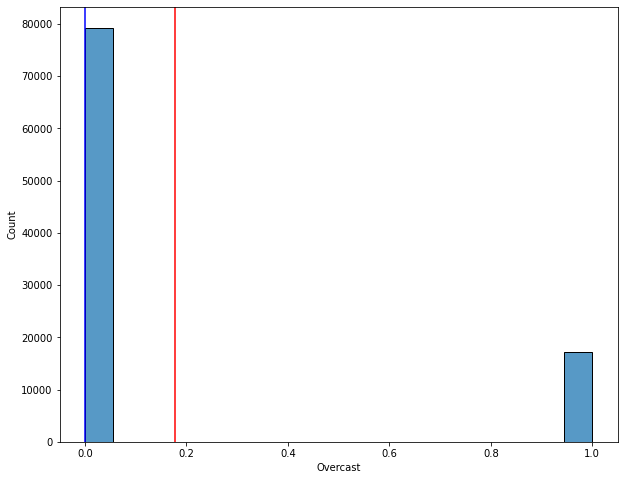

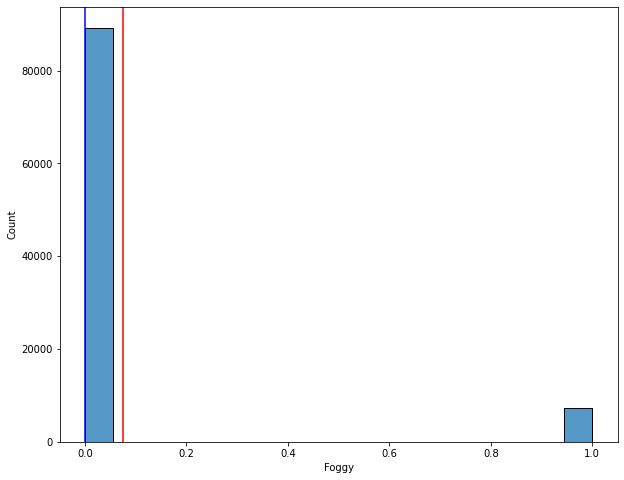

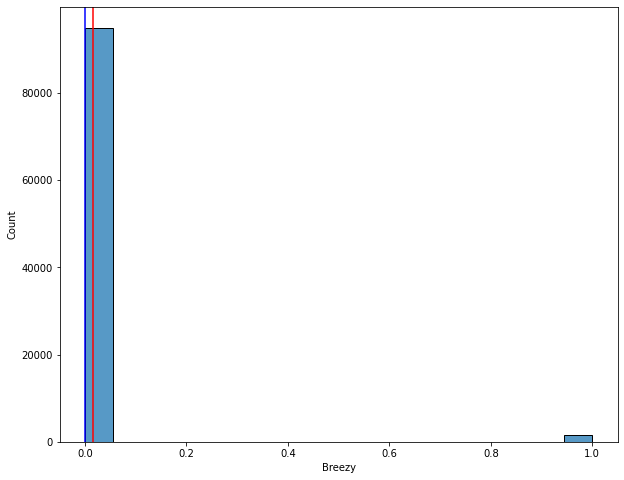

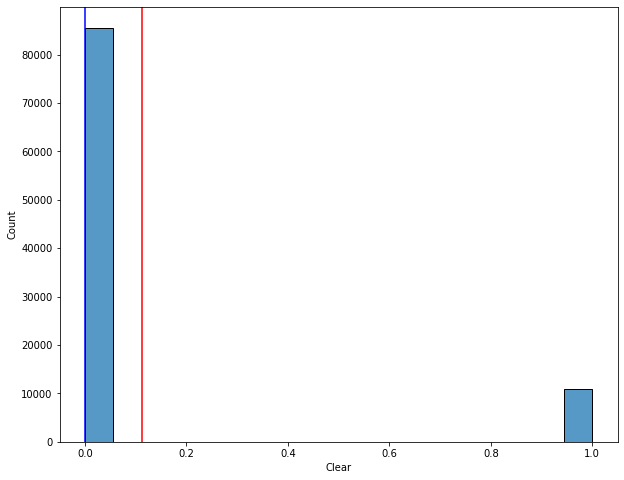

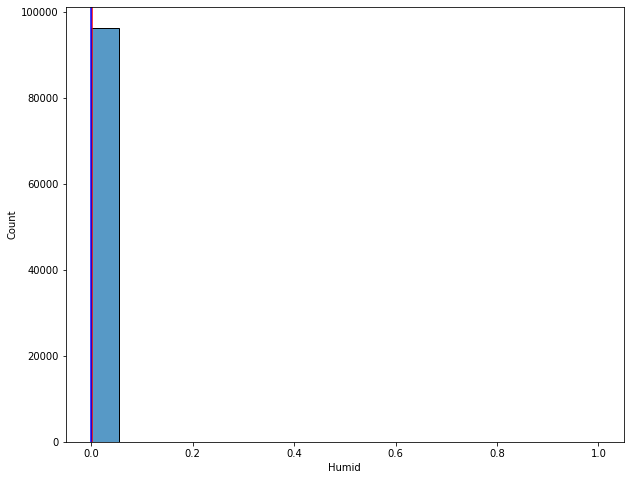

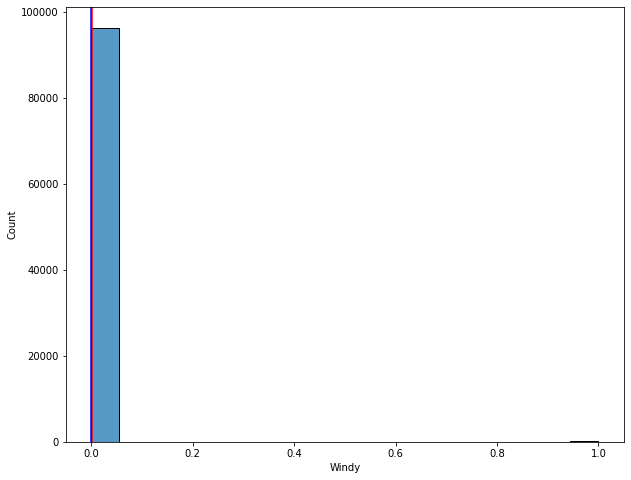

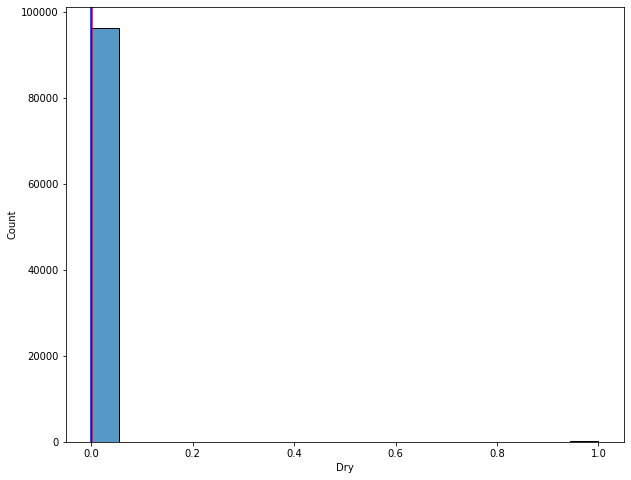

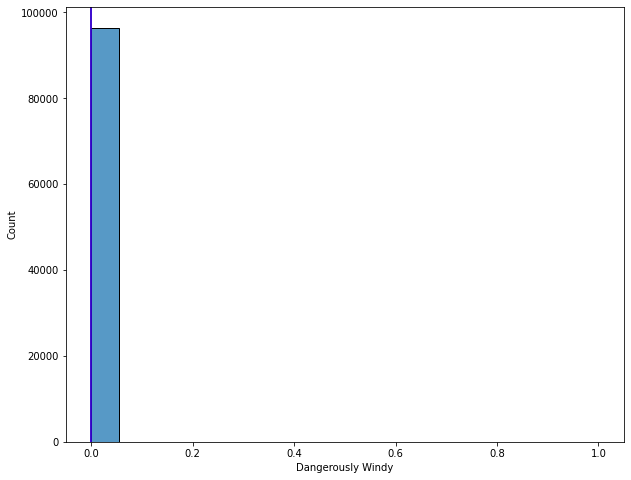

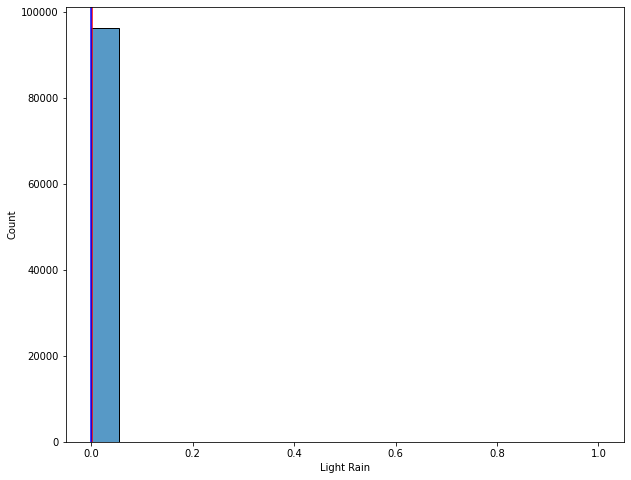

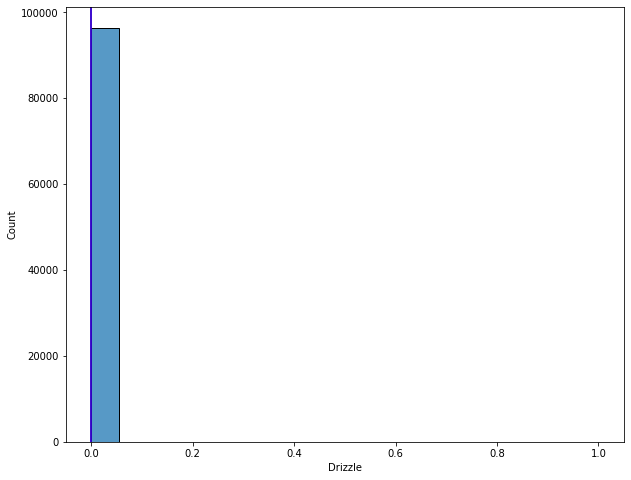

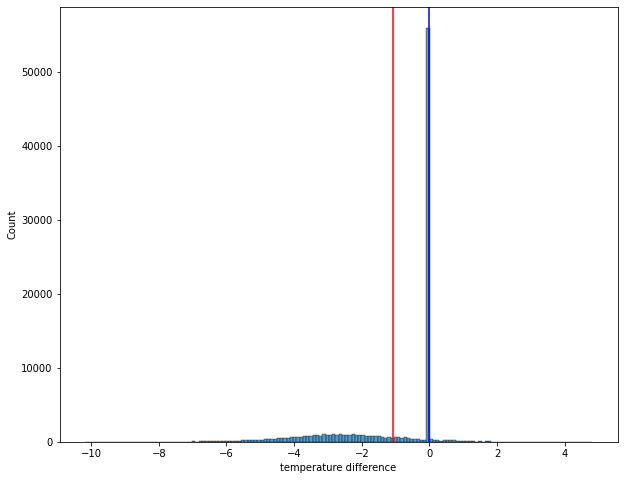

In [26]:
for feature in df.columns:
    if (df[feature].dtypes != 'object'):
        sns.histplot(df, x=feature)
        plt.axvline(x=df[feature].mean(), color='red')
        plt.axvline(x=df[feature].median(), color='blue')
    
        plt.show()

#### Wnioski do histogramów:

Cecha:
- Temperature (C):
rozkład wartości cech dla temperatury jest zbliżony do wykresu rozkładu normalnego - jego średnia i medianą są prawie równe sobie To jest cena objaśniana.

- Wind Bearing (degrees)

- Visibility (km):
najczęściej powtażające sie widoczności dla danych to 9 oraz 16 kilometrów

- Humidity, Wind Speed (km/h):
mają wartości odstające które zostaną poprawione oraz histogramy zostaną wyświetlone ponownie

- Pressure (millibars):
posiada wartości odstające rozne 0, do dla cisnienia nie powinno sie zdażyć. Poniżej zostanieprzeprowadzone usuniecie wartości równych 0.

- Month, Hour, year_season, day_part:
dla każdego z histogramów ilość powtórzeń jest cykliczna, zgodnie z ilością miesięcy oraz godzin ( a także ich grup) w każdym roku od 2006-01-01 00:00 do 2016-12-31 23:00. 

- Rain, Snow:
cechy przyjmują tylko wartości (0,1), oraz wzajemnie sie wykluczają.

- Partly Cloudy, Mostly Cloudy, Overcast, Foggy, Breezy, Clear, Humid, Windy, Dry, Dangerously Windy, Light Rain, Drizzle:
cechy zostały stworzone z 'Summary', przyjmuja wartości (0, 1). Z każdym z nich któraś z vartości dla każdej cechy jest przeważająca. 

- temperature difference:
cecha stworzona na postawie rożnicy między temepratura mierzoną a temperaturą odczuwalną. Najcześciej powtarzającą sie wartością jest 0. Cecha ta nie bedzie brana pod uwage w tworzeniu modelu.


- Daily Summary:
została wykluczona z z wyświetlenia wartości na histogramie, wykre typu boxplot zostanie wyświetlony poniżej.

### Wykrywanie i zamiana wartości odstających oraz wyświetlenei histogramów

Column name: Humidity
3-sigm max 1.3213171835375705	3-sigm min 0.14848074913421072
Max value for Humidity: 1.0	Min value for Humidity: 0.0
Outliers to replace: 28
Outliers number after using a function: 0


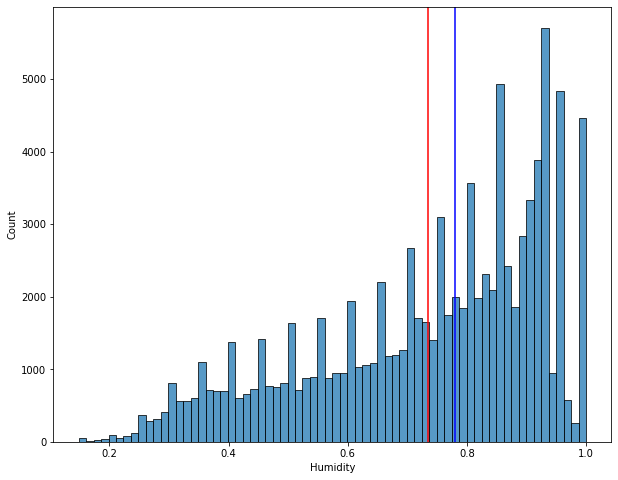


Column name: Wind Speed (km/h)
3-sigm max 31.551353178569663	3-sigm min -9.930072896983248
Max value for Wind Speed (km/h): 63.8526	Min value for Wind Speed (km/h): 0.0
Outliers to replace: 1208
Outliers number after using a function: 0


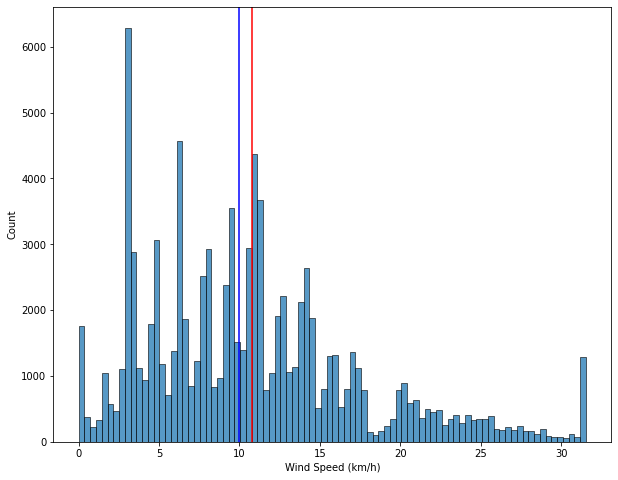


Column name: temperature difference
3-sigm max 3.958433619128259	3-sigm min -6.113732745818629
Max value for temperature difference: 4.811111111111117	Min value for temperature difference: -10.183333333333335
Outliers to replace: 884
Outliers number after using a function: 0


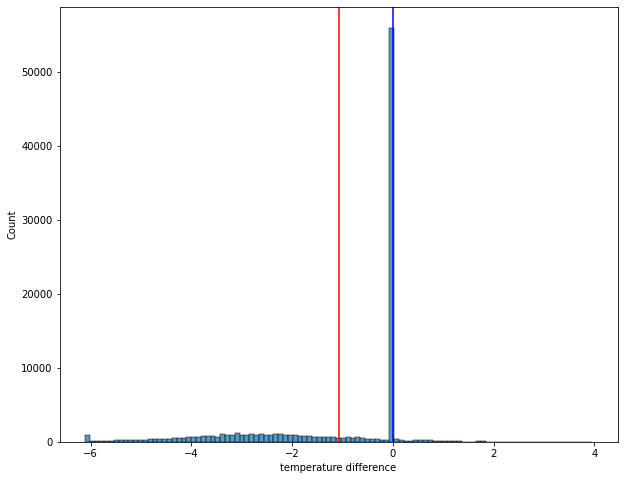

In [27]:
# Chose features to remove outlayers
features_with_outlayers = ['Humidity', 'Wind Speed (km/h)', 'temperature difference']

for col in features_with_outlayers:
    high_3sigm = df[col].mean() + 3*df[col].std()
    low_3sigm = df[col].mean() - 3*df[col].std()
    print(f"Column name: {col}\n3-sigm max {high_3sigm}\t3-sigm min {low_3sigm}")
    print(f"Max value for {col}: {df[col].max()}\tMin value for {col}: {df[col].min()}")
    print("Outliers to replace:", len(df.loc[df[col] < low_3sigm]) + len(df.loc[df[col] > high_3sigm]))
    df.loc[df[col] < low_3sigm, col] = low_3sigm
    df.loc[df[col] > high_3sigm, col] = high_3sigm
    print("Outliers number after using a function:", len(df.loc[df[col] < low_3sigm]) + len(df.loc[df[col] > high_3sigm]))
    sns.histplot(df, x=col)
    plt.axvline(x=df[col].mean(), color='red')
    plt.axvline(x=df[col].median(), color='blue')
    
    plt.show()
    print("")

#### Wnioski:
Zastosowanie metody 3 sigm skutecznie zredukowało wartosci odstajace dla cech Humidity, Wind Speed (km/h)

### Usunięcie zer dla 'Pressure (millibars)'

In [28]:
# TO DEVELOP IN THE FUTURE
"""
# data fram without 'Pressure (millibars)'==0
df_pressure_no_0 = df.loc[df['Pressure (millibars)']!=0]
print("shape:", df_pressure_no_0.shape)
df_pressure_no_0.head()

#check corelation for 'Pressure (millibars)'
np.abs(df_pressure_no_0.corr()).loc[:,['Pressure (millibars)']].sort_values(by = 'Pressure (millibars)', ascending = False)

# TODO WARTOSCI 0 DLA CISNIENIA
df_pressure_0 = df.loc[df['Pressure (millibars)']==0]


# TODO create samples to tests function belowe - TODO CHOOSE RIGHT features
smpl = df_pressure_0.sample(1)
temperature = np.round(smpl['Temperature (C)'].values[0], 3)
wind_speed = np.round(smpl['Wind Speed (km/h)'].values[0],3)
visibility = np.round(smpl['Visibility (km)'].values[0], 3)
temperature, wind_speed, visibility



# TODO Script to giving similar features for chosen featrues - change features for adaptation of features
tsub = 0.2
wsub = 0.2
vsub = 0.2

pre_last_su = ""
last_su = ""

number_of_elements_in_the_df = 4

chosen_df = pd.DataFrame()
while len(chosen_df) < number_of_elements_in_the_df:
    chosen_df = df.loc[(
        lambda df: (
            (df['Pressure (millibars)'] != 0)
            & (np.round(df['Wind Speed (km/h)'], 3).between(wind_speed-wsub, wind_speed+wsub)) 
            & (np.round(df['Temperature (C)'], 3).between(temperature-tsub, temperature+tsub))
            & (np.round(df['Visibility (km)'], 3).between(visibility-vsub, visibility+vsub)) 
        ))]

    
    temp_diff = 0.5
    wind_diff = 0.2
    vis_diff = 0.2
    
    
    if last_su == '':
        last_su = "tsub"
        tsub += temp_diff
        print("last ", last_su, "pre last ", pre_last_su)
    elif pre_last_su == "":
        pre_last_su = last_su # tsub
        last_su = "wsub"
        wsub += wind_diff
        print("last ", last_su, "pre last ", pre_last_su)
    elif last_su == 'wsub':
        pre_last_su = last_su # wsub
        last_su = 'vsub'
        vsub += vis_diff
        print("last ", last_su, "pre last ", pre_last_su)
    elif last_su == 'vsub':
        pre_last_su = last_su # wsub
        last_su = 'tsub'
        tsub += temp_diff
        print("last ", last_su, "pre last ", pre_last_su)
    elif last_su == 'tsub':
        pre_last_su = last_su # wsub
        last_su = 'wsub'
        tsub += temp_diff
        print("last ", last_su, "pre last ", pre_last_su)

                                           
                                           
# data frame for check std and mean for  'Pressure (millibars)'

press_diff = 0.01
col_df= chosen_df['Pressure (millibars)'].loc[chosen_df['Pressure (millibars)'].between(
    chosen_df['Pressure (millibars)'].min()+press_diff, chosen_df['Pressure (millibars)'].max()-press_diff
)]
std = col_df.std()
mean = col_df.mean()
std, mean                                                                                                               

"""

'\n# data fram without \'Pressure (millibars)\'==0\ndf_pressure_no_0 = df.loc[df[\'Pressure (millibars)\']!=0]\nprint("shape:", df_pressure_no_0.shape)\ndf_pressure_no_0.head()\n\n#check corelation for \'Pressure (millibars)\'\nnp.abs(df_pressure_no_0.corr()).loc[:,[\'Pressure (millibars)\']].sort_values(by = \'Pressure (millibars)\', ascending = False)\n\n# TODO WARTOSCI 0 DLA CISNIENIA\ndf_pressure_0 = df.loc[df[\'Pressure (millibars)\']==0]\n\n\n# TODO create samples to tests function belowe - TODO CHOOSE RIGHT features\nsmpl = df_pressure_0.sample(1)\ntemperature = np.round(smpl[\'Temperature (C)\'].values[0], 3)\nwind_speed = np.round(smpl[\'Wind Speed (km/h)\'].values[0],3)\nvisibility = np.round(smpl[\'Visibility (km)\'].values[0], 3)\ntemperature, wind_speed, visibility\n\n\n\n# TODO Script to giving similar features for chosen featrues - change features for adaptation of features\ntsub = 0.2\nwsub = 0.2\nvsub = 0.2\n\npre_last_su = ""\nlast_su = ""\n\nnumber_of_elements_in_the

In [29]:
# delate the rows where 'Pressure (millibars)']!=0
df = df.loc[df['Pressure (millibars)']!=0]
print("Shape", df.shape)
df.head()

Shape (95165, 26)


,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Month,Hour,year_season,...,Foggy,Breezy,Clear,Humid,Windy,Dry,Dangerously Windy,Light Rain,Drizzle,temperature difference
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,Partly cloudy throughout the day.,4,0,2,...,0,0,0,0,0,0,0,0,0,-2.083333
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,Partly cloudy throughout the day.,4,1,2,...,0,0,0,0,0,0,0,0,0,-2.127778
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,Partly cloudy throughout the day.,4,2,2,...,0,0,0,0,0,0,0,0,0,0.000000
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,Partly cloudy throughout the day.,4,3,2,...,0,0,0,0,0,0,0,0,0,-2.344444
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,Partly cloudy throughout the day.,4,4,2,...,0,0,0,0,0,0,0,0,0,-1.777778


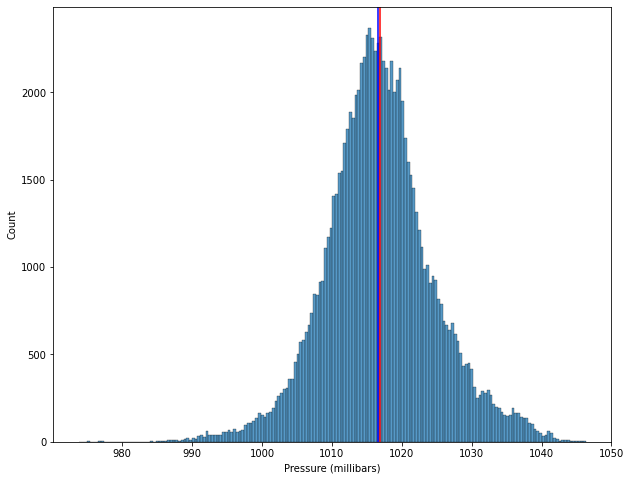

In [30]:
# dispay histogram dor feature 'Pressure (millibars)'
sns.histplot(df, x='Pressure (millibars)')
plt.axvline(x=df['Pressure (millibars)'].mean(), color='red')
plt.axvline(x=df['Pressure (millibars)'].median(), color='blue')
    
plt.show()

#### Wnioski:
Po usunięciu wartości zero dla 'Pressure (millibars)' histogram jest zbliżony do wykresu rozkładu normalnego

### Wyświetlenie wykresów punktowych dla cech względem "Temperature (C)" (zmienna objaśniana)

Scaterplot ynie zostaną wyświetlone dla danych ktore przyjmują wartości 1 lub 0, oraz dla cech ktore są zwiazane z data i godziną lub są danymi objektowymi

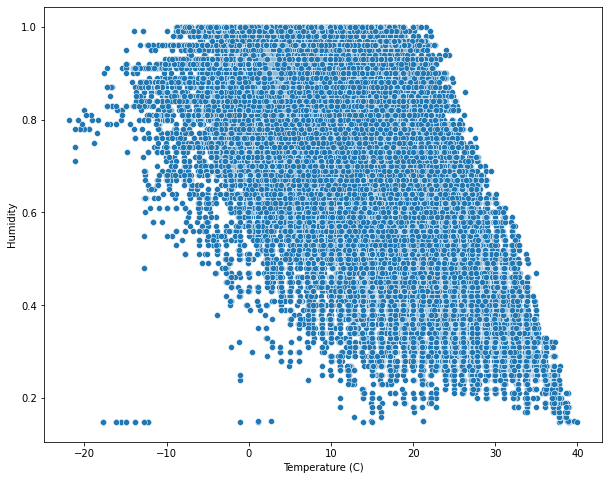

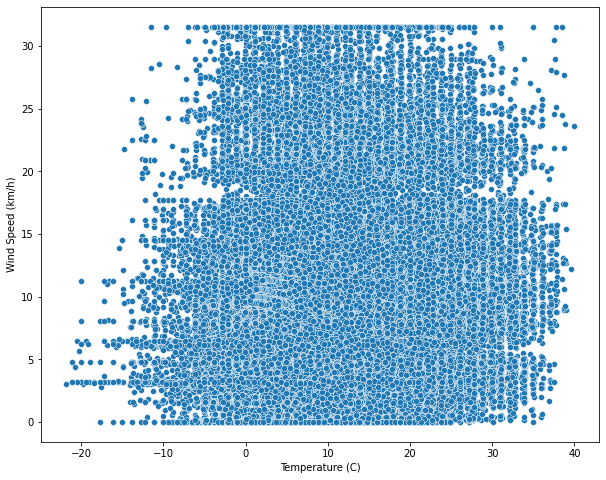

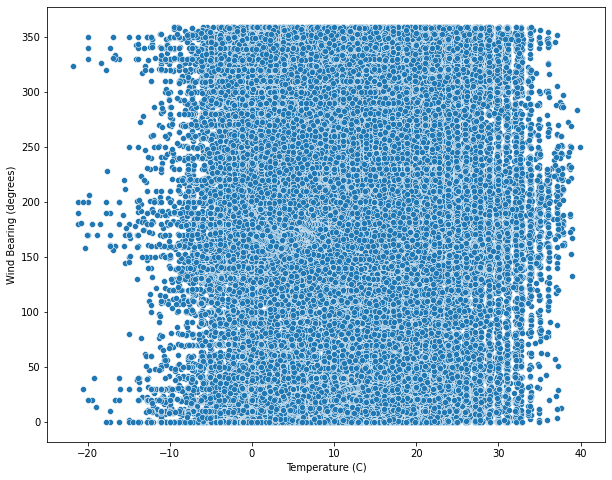

In [ ]:
features = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 
            'Pressure (millibars)', 'temperature difference']

for col in df[features].drop(columns = ["Temperature (C)"]):
    sns.scatterplot(data = df[features], x = "Temperature (C)", y = col)
    plt.show()

#### Wnioski
Przedstawione cechy:'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',  'Pressure (millibars)', 'temperature difference' posiadają duże rozrzuty danacy względe mcechy objaśnianej <br>

wykres punktowy dla cechy 'temperature difference' ma rozrzu bardzo nieregularny - ta cecha nie bedzie brała udziału w tworzeniu modelu, poniewaz została stworzona z warosci objasnianej oraz objasniającej

### Wizualizacja 'Daily Summary' na boxplot

In [ ]:
sns.set_theme(style="ticks")
# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(20, 40))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot (x='Temperature (C)', y='Daily Summary', data=df)
# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)
plt. show()

#### Wnioski:

Kolumna Daily Summary posiada wiele unikalnych wartości, nie będzie bran pod uwage podczas wyskonywania modelu, pownieważ nie jesteśmy w stanie przeznaczyć  czasu na jej opracowanie.

In [ ]:
# drop "Daily Summary"
df = df.drop("Daily Summary", axis=1)
print("Shape: ", df.shape)

### Usunięcie Cechy 'Snow'

In [ ]:
df[['Rain', 'Snow']].hist()

In [ ]:
df = df.drop("Snow", axis=1)
print("Shape: ", df.shape)

#### Wnioski:
Cechy 'Snow' oraz 'Rain' wjazemnie sie wykluczają, dlatego na potrzeby projektu 'Snow' zostaje usunięty.

# Wybór cech